In [18]:
import sys
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import os
from datetime import datetime,timedelta
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from xgboost import XGBClassifier
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.integrate import simps
import seaborn as sns

font = {'family' : 'normal','size'   : 20}
plt.rc('font', **font)
plt.rc('figure', titlesize=16)

if 'imac' in os.getcwd():
    macFlag=True
else:
    macFlag=False

In [19]:
testDays=np.array([[datetime(2018,7,20),datetime(2018,7,13),datetime(2018,7,27),datetime(2018,7,10),datetime(2018,6,22),datetime(2018,7,3),datetime(2018,7,17),datetime(2018,6,25),datetime(2018,7,24)],
           [datetime(2018,7,19),datetime(2018,6,28),datetime(2018,7,20),datetime(2018,7,27),datetime(2018,7,3),datetime(2018,6,22),datetime(2018,7,26),datetime(2018,6,29),datetime(2018,7,13)],
           [datetime(2018,8,16),datetime(2018,8,8),datetime(2018,8,10),datetime(2018,7,30),datetime(2018,8,20),datetime(2018,8,3),datetime(2018,8,1),datetime(2018,8,17),datetime(2018,8,15)],
           [datetime(2018,8,28),datetime(2018,8,15),datetime(2018,8,14),datetime(2018,8,29),datetime(2018,8,20),datetime(2018,8,22),datetime(2018,8,27),datetime(2018,8,21),datetime(2018,8,16)],
           [datetime(2018,9,6),datetime(2018,9,13),datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,20),datetime(2018,9,11),datetime(2018,9,17),datetime(2018,9,5),datetime(2018,9,4)],
           [datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,25),datetime(2018,9,13),datetime(2018,10,3),datetime(2018,10,2),datetime(2018,9,27),datetime(2018,9,17),datetime(2018,9,26)],
           [datetime(2018,10,4),datetime(2018,10,9),datetime(2018,9,25),datetime(2018,10,11),datetime(2018,9,26),datetime(2018,10,3),datetime(2018,10,10),datetime(2018,9,27),datetime(2018,10,2)]
           ]).astype(datetime)

testDaysMealNumbers=np.zeros((7,9,2))
for i in range(7):
    for j in range(9):
        tempDay=testDays[i,j]
        testDaysMealNumbers[i,j,0]=tempDay.timetuple().tm_yday
        testDaysMealNumbers[i,j,1]=j

In [20]:
#Separating the test days from normal ones
def dataSanitizer(rootAddressAllData,rootAddressSanitized):
    os.chdir(rootAddressAllData)
    patientName=['38A','38B','38C','38D','38E','38F','38H']
    fileNames=os.listdir()

    for fileName in fileNames:
        for counter in range(7):
            if(patientName[counter] in fileName):
                currentPatient=counter
                break
        print(fileName)
        myDf=pd.read_csv(fileName)
        for myColumn in myDf.columns:
            if myColumn not in ['time','BG','Participant']:
                del myDf[myColumn]
        myDf=myDf.dropna()
        myDf=myDf.drop_duplicates(subset=['time'], keep='last')
        myDf['time']= pd.to_datetime(myDf['time'])

        myDf.insert(3,"StandardTest",0)
        for rowCounter in range(0,len(myDf)):
            for counter in range(0,9):
                if myDf.iloc[rowCounter,1].date()==testDays[currentPatient][counter].date():
                    myDf.iloc[rowCounter,3]=counter+1
                    break

        myDf=myDf[myDf.StandardTest > 0]
        myFileAddress=rootAddressSanitized+patientName[currentPatient]+'.csv'
        myDf.to_csv(myFileAddress,index = False)

if not macFlag:
    rootAddressAllData=r'C:\GitHub\STMI-CGM\Selected-38'
    rootAddressSanitized=r'C:\GitHub\STMI-CGM\Sanitized38\TestDays_'
else:
    #---------------------AMIN
    rootAddressAllData=r'C:\GitHub\STMI-CGM\Selected-38'
    rootAddressSanitized=r'C:\GitHub\STMI-CGM\Sanitized38\TestDays_'
dataSanitizer(rootAddressAllData,rootAddressSanitized)

overall_spread_sheet_38A.csv
overall_spread_sheet_38B.csv
overall_spread_sheet_38C.csv
overall_spread_sheet_38D.csv
overall_spread_sheet_38E.csv
overall_spread_sheet_38F.csv
overall_spread_sheet_38H.csv


Reading..... TestDays_38A.csv
The BG base line is not found for 176 and we used 80.0001
The best model for participant: 38A has accuracy= 93.7 recall= 100.0 precision= 88.8
Threshold= 0.4 tree number= 9 max depth= 9 positive weight= 63.2
------------------------------------------------
The importance of each feature is shown below (the averaged value of all cases)
('Average', 12.7)
('STD', 4.4)
('Min', 10.7)
('Max', 7.8)
('Min Slope', 6.5)
('Max Slope', 6.4)
('1st half slope', 24.0)
('2nd half slope', 11.8)
('Integral Value', 5.2)
('Min Concavity', 6.1)
('Max Concavity', 4.5)


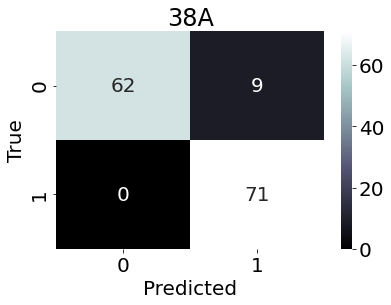

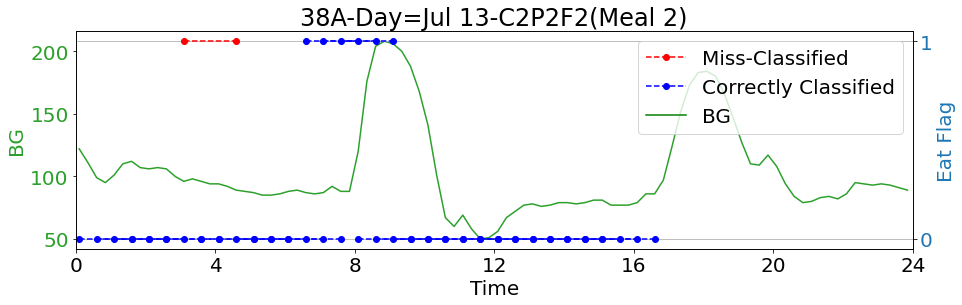

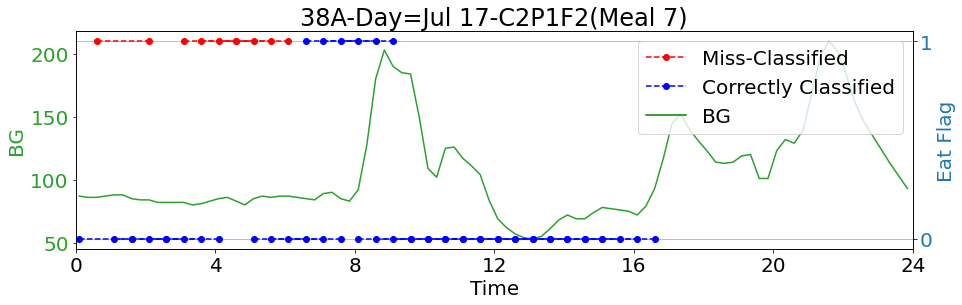

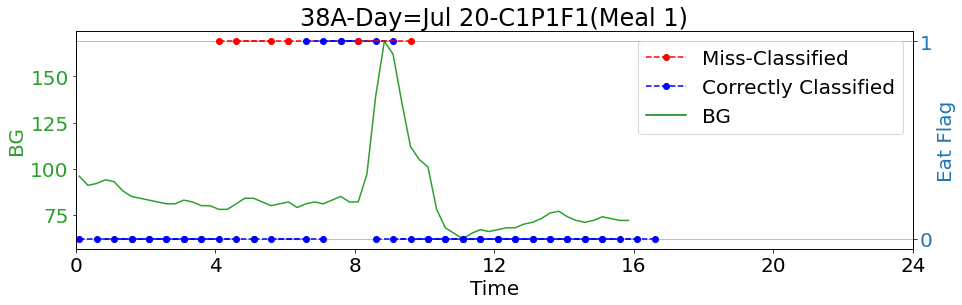

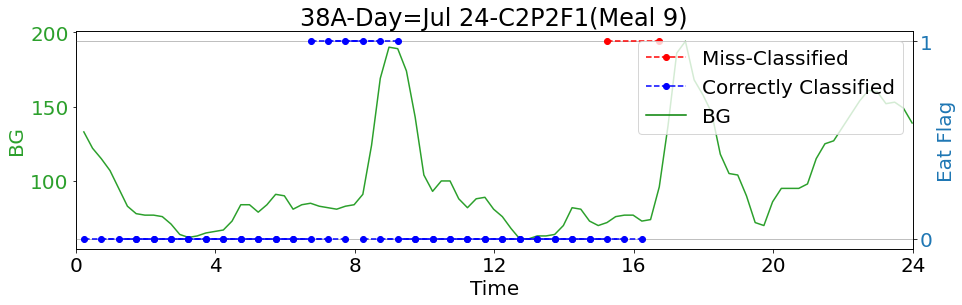

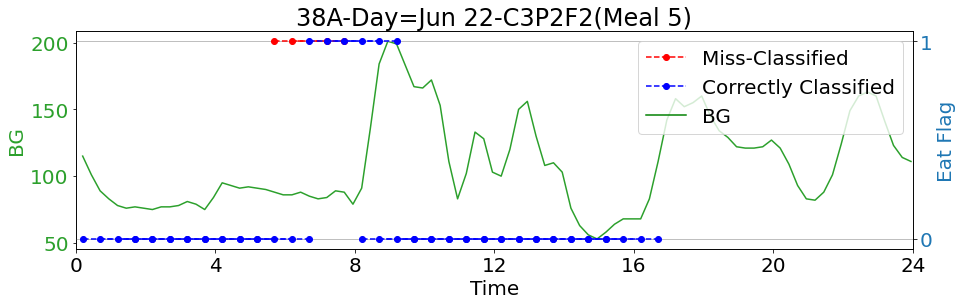

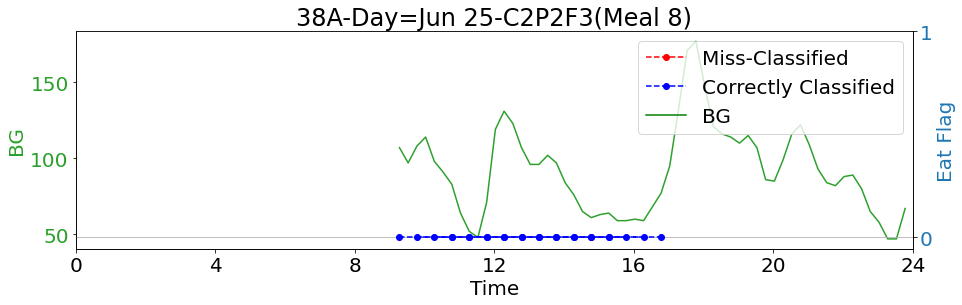

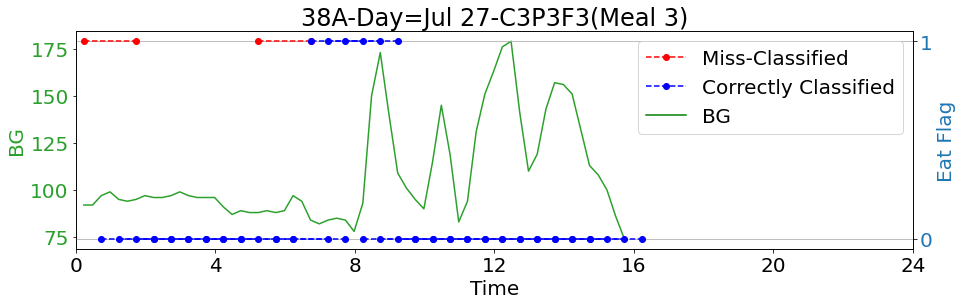

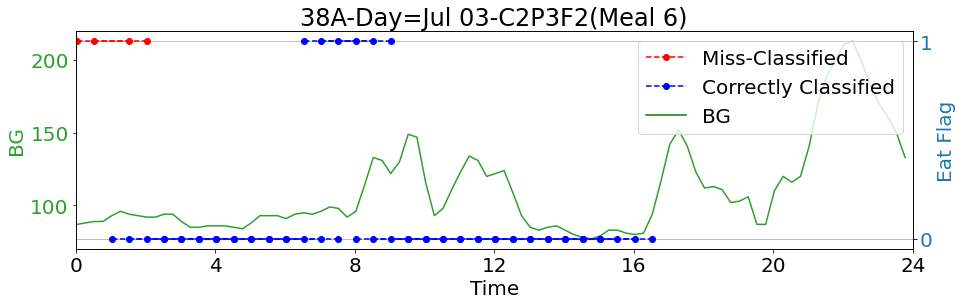

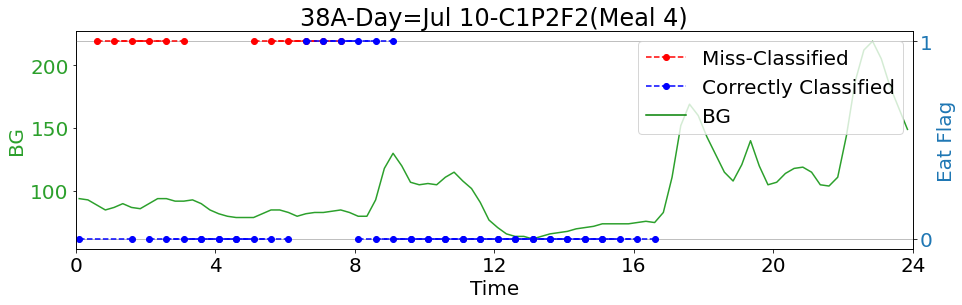

In [21]:
#------------AMIN PLEASE IMPLEMNET THE LOGISTIC REGRESSION AND SVM HERE USING THE SAME FORMAT FOR THE HYPERPARAMETERS-------------

#Setting Random Forest algorithm and testing all hyper-parameters
def STMI_random_forest(trainData,testData,trainLabels,testLabels,patientName):
    treeNumBest=-1
    posWeightBest=-1
    maxDepthBest=-1
    accuracyBest=-1
    recallBest=-1
    precisionBest=-1
    confMatrixBest=[]
    for threshold in np.arange(0.4,0.8,0.2):
        for treeNum in np.arange(3,10):
            for maxDepth in np.arange(3,10):
                for posWeight in np.arange(1,4,0.5):
                    posWeight=0.2*10**posWeight
                    clf=RandomForestClassifier(n_estimators=treeNum,criterion='entropy',random_state=0,max_depth=maxDepth,class_weight={0: 1, 1: posWeight})
                    clf.fit(trainData,trainLabels)
                    sliddingWindowPrediction=clf.predict_proba(testData)
                    sliddingWindowPrediction=sliddingWindowPrediction[:,1]
                    sliddingWindowPrediction[sliddingWindowPrediction>=threshold]=1
                    sliddingWindowPrediction[sliddingWindowPrediction<threshold]=0

                    confMatrix=sklearn.metrics.confusion_matrix(testLabels,sliddingWindowPrediction)
                    accuracy=sklearn.metrics.accuracy_score(testLabels,sliddingWindowPrediction)
                    recall=sklearn.metrics.recall_score(testLabels,sliddingWindowPrediction)
                    precision=sklearn.metrics.precision_score(testLabels,sliddingWindowPrediction)

                    if(accuracy>=accuracyBest and recall>=recallBest):
                        confMatrixBest=confMatrix
                        threshBest=threshold

                        accuracyBest=accuracy
                        recallBest=recall
                        precisionBest=precision

                        modelBest=clf
                        treeNumBest=treeNum
                        posWeightBest=posWeight
                        maxDepthBest=maxDepth

    features=np.round(modelBest.feature_importances_*100,1)
    print("The best model for participant:",patientName,"has accuracy=",round(accuracyBest*100,1)
          ,"recall=",round(recallBest*100,1),"precision=",round(precisionBest*100,1))
    print("Threshold=",round(threshBest,2),"tree number=",treeNumBest,"max depth=",maxDepthBest,
          "positive weight=",round(posWeightBest,1))
    plt.figure()
    sns.heatmap(confMatrixBest, annot=True,cmap='bone')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(patientName)
    if not macFlag:
        file_name = "C:\GitHub\STMI-CGM\Sanitized38\RF"+patientName+".pkl"
    else:
        #AMIN
        file_name=''
    pickle.dump(modelBest, open(file_name, "wb"))
    return modelBest,threshBest,features

#Setting XGBoost algorithm and testing all hyper-parameters
def STMI_XGBoost(trainData,testData,trainLabels,testLabels,patientName):
    etaBest=-1
    maxDepthBest=-1
    posWeightBest=-1
    accuracyBest=-1
    recallBest=-1
    precisionBest=-1
    confMatrixBest=[]
    for threshold in np.arange(0.4,0.8,0.2):
        for eta in np.arange(0.05,0.50,0.05):
            for maxDepth in np.arange(3,10):
                for posWeight in np.arange(1,4,0.5):
                    posWeight=0.2*10**posWeight

                    clf = XGBClassifier(eta=eta,max_depth=maxDepth,scale_pos_weight=posWeight,objective = "binary:logistic",eval_metric = "logloss",use_label_encoder =False)
                    clf.fit(trainData, trainLabels)
                    sliddingWindowPrediction = clf.predict_proba(testData)
                    sliddingWindowPrediction=sliddingWindowPrediction[:,1]
                    sliddingWindowPrediction[sliddingWindowPrediction>=threshold]=1
                    sliddingWindowPrediction[sliddingWindowPrediction<threshold]=0

                    confMatrix=sklearn.metrics.confusion_matrix(testLabels,sliddingWindowPrediction)
                    accuracy=sklearn.metrics.accuracy_score(testLabels,sliddingWindowPrediction)
                    recall=sklearn.metrics.recall_score(testLabels,sliddingWindowPrediction)
                    precision=sklearn.metrics.precision_score(testLabels,sliddingWindowPrediction)

                    if accuracy>=accuracyBest and recall>=recallBest:
                        confMatrixBest=confMatrix
                        accuracyBest=accuracy
                        recallBest=recall
                        precisionBest=precision

                        etaBest=eta
                        maxDepthBest=maxDepth
                        posWeightBest=posWeight
                        threshBest=threshold
                        modelBest=clf

    features=np.round(modelBest.feature_importances_*100,1)

    print("The best model for participant:",patientName,"has accuracy=",round(accuracyBest*100,1)
          ,"recall=",round(recallBest*100,1),"precision=",round(precisionBest*100,1))
    print("Threshold=",round(threshBest,2),"eta=",round(etaBest,2),"max depth=",maxDepthBest,
          "positive weight=",round(posWeightBest,2))
    plt.figure()
    sns.heatmap(confMatrixBest, annot=True,cmap='bone')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(patientName)
    if not macFlag:
        file_name = "C:\GitHub\STMI-CGM\Sanitized38\XG"+patientName+".pkl"
    else:
        #AMIN
        file_name=''
    pickle.dump(modelBest, open(file_name, "wb"))

    return modelBest,threshBest,features

#Finding the fasting blood glucose value for each day
def fastingBGFinder(query,currentDay):
    fastingBG=80.0001
    fastingQuery=query[query['Time']>=3]
    fastingQuery=fastingQuery[fastingQuery['Time']<=6]

    if(not np.isnan(fastingQuery.BG.mean())):
        fastingBG=fastingQuery.BG.mean()
    else:
        print("The BG base line is not found for",currentDay,"and we used 80.0001")
    return fastingBG

#Calculating the statistics for each slidding window
def statCalculator(query,baseLine):
    integralValue=simps(query.iloc[:,3]-baseLine,x=query.iloc[:,2])

    maxSlopeValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    maxSlopeValue=np.max(maxSlopeValue)

    minSlopeValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    minSlopeValue=np.min(minSlopeValue)

    pointNum=len(query)-1
    if query.iloc[int(pointNum/2),2]==query.iloc[0,2]:
        print(query)
        sys.exit('The window qurery is not big enough. The minimum window duration should be more than 1 hour')

    firstHalfSlope=query.iloc[int(pointNum/2),3]-query.iloc[0,3]
    firstHalfSlope/=query.iloc[int(pointNum/2),2]-query.iloc[0,2]

    secondHalfSlope=query.iloc[pointNum,3]-query.iloc[int(pointNum/2),3]
    secondHalfSlope/=query.iloc[pointNum,2]-query.iloc[int(pointNum/2),2]

    maxConcavityValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    maxConcavityValue=np.gradient(maxConcavityValue,query.iloc[:,2])
    maxConcavityValue=np.max(maxConcavityValue)

    minConcavityValue=np.gradient(query.iloc[:,3]-baseLine,query.iloc[:,2])
    minConcavityValue=np.gradient(minConcavityValue,query.iloc[:,2])
    minConcavityValue=np.min(minConcavityValue)

    meanValue=query['BG'].mean()-baseLine
    stdValue=query['BG'].std()
    minValue=query['BG'].min()-baseLine
    maxValue=query['BG'].max()-baseLine

    return meanValue,stdValue,minValue,maxValue,minSlopeValue,maxSlopeValue,firstHalfSlope,secondHalfSlope,integralValue,minConcavityValue,maxConcavityValue

#Chopping the data into daily values and forming the sliddingWindow
def sliddingWindowMaker(allDays,rawData):
    sliddingWindow=[]
    sliddingWindowLabel=[]
    for dayCounter in range(len(allDays)):
        currentDay=allDays[dayCounter]
        dayQuery=rawData[rawData['Day of Year']==currentDay]
        startTime=dayQuery.iloc[0,2]
        endTime=startTime+timeWindow
        fastingBG=fastingBGFinder(dayQuery,currentDay)

        windowQuery=dayQuery[dayQuery['Time']>=startTime]
        windowQuery=windowQuery[windowQuery['Time']<endTime]
        while len(windowQuery)>=(timeWindow*4/2):
            if endTime>17:
                break #after 4PM the participants go home and they don't hold the criteria anymore
            if startTime<=breakfastTime and endTime>=breakfastTime:
                eatFlag=1
            else:
                eatFlag=0
            statInfo=statCalculator(windowQuery,fastingBG)
            statInfo=list(statInfo)
            statInfo.extend([startTime,endTime,currentDay])
            sliddingWindow.append(statInfo)
            sliddingWindowLabel.append(eatFlag)

            startTime+=timeStep
            endTime+=timeStep
            windowQuery=dayQuery[dayQuery['Time']>=startTime]
            windowQuery=windowQuery[windowQuery['Time']<endTime]

    sliddingWindow=np.array(sliddingWindow,dtype=float)
    sliddingWindowLabel=np.array(sliddingWindowLabel,dtype=int)
    return sliddingWindow,sliddingWindowLabel

#Reading the CSV for each participant and calculating the day of year and time (decimal format)
def csvReader(csvAddress):
    rawData=pd.read_csv(csvAddress)
    for myColumn in rawData.columns:
        if myColumn not in ['time','BG','Participant']:
            del rawData[myColumn]

    rawData['time']= pd.to_datetime(rawData['time'])
    rawData['BG']= pd.to_numeric(rawData['BG'])

    rawData=rawData.dropna()
    rawData=rawData.drop_duplicates(subset=['time'], keep='last')

    rawData.insert(2, "Day of Year",rawData['time'].dt.dayofyear)
    rawData.insert(3, "Time",rawData['time'].dt.hour+
                   rawData['time'].dt.minute/60+rawData['time'].dt.second/3600)
    rawData=rawData.drop(columns=['time'])
    rawData=rawData.sort_values(['Day of Year', 'Time'], ascending=[True, True])

    allDays=rawData['Day of Year'].tolist()
    allDays=set(allDays)
    allDays=list(allDays)
    return allDays,rawData

#Splitting the data into train and test
def dataSplitter(sliddingWindow,sliddingWindowLabel):
    balancedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state=2)
    for trainIndex, testIndex in balancedSplit.split(sliddingWindow, sliddingWindowLabel):
        trainData, testData = sliddingWindow[trainIndex,:], sliddingWindow[testIndex,:]
        trainLabel, testLabel = sliddingWindowLabel[trainIndex], sliddingWindowLabel[testIndex]
    return trainData,testData,trainLabel,testLabel

#Balacing the sliddingWindow data using SMOTE
def dataBalancer(sliddingWindow,sliddingWindowLabel):
    oversample = SMOTE()
    sliddingWindowSMOTE, sliddingWindowLabelSMOTE = oversample.fit_resample(sliddingWindow, sliddingWindowLabel)
    return sliddingWindowSMOTE, sliddingWindowLabelSMOTE

#Plotting the BG time-series and the binary classification results on top of that
def windowVisualizer(rawData,bestModel,bestThreshold,testMealNum,patientName,sliddingWindow, sliddingWindowLabel, startTime,endTime,days):
    mealContent=['C1P1F1','C2P2F2','C3P3F3',
                 'C1P2F2','C3P2F2','C2P3F2',
                 'C2P1F2','C2P2F3','C2P2F1']
    allDays=set(days)
    allDays=list(allDays)
    for dayCounter in range(len(allDays)):
        fig, ax1 = plt.subplots(figsize=(15,4))
        newQuery=rawData[rawData['Day of Year']==allDays[dayCounter]]

        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('BG', color=color)
        ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim([0,24])
        ax1.set_xticks(np.arange(0, 26, 4))

        tempData=[]
        tempLabel=[]
        tempStart=[]
        tempEnd=[]
        for counter in range(sliddingWindow.shape[0]):
            if days[counter]==allDays[dayCounter]:
                tempData.append(sliddingWindow[counter,:])
                tempLabel.append(sliddingWindowLabel[counter])
                tempStart.append(startTime[counter])
                tempEnd.append(endTime[counter])

        tempData=np.array(tempData,dtype=float)
        tempLabel=np.asarray(tempLabel,dtype=int)
        tempStart=np.asarray(tempStart,dtype=float)
        tempEnd=np.asarray(tempEnd,dtype=float)

        if len(tempData)==0:
            sys.exit(("--------Warning, the slidding window is empty for prediction on day:"+allDays[dayCounter]))

        tempPred=bestModel.predict_proba(tempData)
        tempPred=tempPred[:,1]
        tempPred[tempPred>=bestThreshold]=1
        tempPred[tempPred<bestThreshold]=0

        ax2 = ax1.twinx()
        for counter in range(len(tempPred)):
            if tempPred[counter]==tempLabel[counter]:
                ax2.plot([tempStart[counter],tempEnd[counter]],np.ones((2,1))*tempPred[counter],
                         linestyle='--', marker='o', color='b')
            else:
                ax2.plot([tempStart[counter],tempEnd[counter]],np.ones((2,1))*tempPred[counter],
                         linestyle='--', marker='o', color='r')
        ax2.plot([],[],linestyle='--', marker='o', color='r',label='Miss-Classified')
        ax2.plot([],[],linestyle='--', marker='o', color='b',label='Correctly Classified')
        ax2.plot([],[],linestyle='-', color='g',label='BG')
        ax2.legend()
        for counter in range(9):
            if testMealNum[counter,0]==allDays[dayCounter]:
                tempMealName=testMealNum[counter,1]
        tempMealName=int(tempMealName)
        tempDate=datetime(2018, 1, 1) + timedelta(allDays[dayCounter] - 1)
        tempDate=tempDate.strftime("%b %d")
        plt.title(patientName+"-Day="+tempDate+"-"+mealContent[tempMealName]+
                  "(Meal "+str(tempMealName+1)+")",color='black')

        color='tab:blue'
        ax2.set_ylabel('Eat Flag', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([0,1])
        ax2.set_xlim([0,24])
        ax2.set_xticks(np.arange(0, 26, 4))

        plt.grid()
        plt.show()

#Calling the model (RF or XGBoost) and returning the model details to the main function
def modelTrainer(modelingMethod,trainData,testData,trainLabel,testLabel,patientName):
    if modelingMethod=='RF':
        modelResult=STMI_random_forest(trainData,testData,trainLabel,testLabel,patientName)
    if modelingMethod=='XG':
        modelResult=STMI_XGBoost(trainData,testData,trainLabel,testLabel,patientName)
    return modelResult

def featureInterpretor(featureImportance):
    featureImportance=np.asarray(featureImportance,dtype=float)
    featureImportance=np.mean(featureImportance,axis=0)
    featureImportance=np.round(featureImportance,2)
    feat_labels = ['Average','STD','Min','Max','Min Slope', 'Max Slope','1st half slope','2nd half slope','Integral Value','Min Concavity','Max Concavity']
    print("The importance of each feature is shown below (the averaged value of all cases)")
    for feature in zip(feat_labels,featureImportance):
        print(feature)

#Setting the patientName and testMealNumber for each patient based on the CSV fileName
def participantReaderAux(fileName):
    if (fileName=='TestDays_38A.csv'):
        patientName='38A'
        testMealNum=testDaysMealNumbers[0,:,:]
    if (fileName=='TestDays_38B.csv'):
        patientName='38B'
        testMealNum=testDaysMealNumbers[1,:,:]
    if (fileName=='TestDays_38C.csv'):
        patientName='38C'
        testMealNum=testDaysMealNumbers[2,:,:]
    if (fileName=='TestDays_38D.csv'):
        patientName='38D'
        testMealNum=testDaysMealNumbers[3,:,:]
    if (fileName=='TestDays_38E.csv'):
        patientName='38E'
        testMealNum=testDaysMealNumbers[4,:,:]
    if (fileName=='TestDays_38F.csv'):
        patientName='38F'
        testMealNum=testDaysMealNumbers[5,:,:]
    if (fileName=='TestDays_38H.csv'):
        patientName='38H'
        testMealNum=testDaysMealNumbers[6,:,:]
    return patientName,testMealNum

#The main function which 1)sets the meal details and participant name, 2)reads the participant CSV data,
# 3)forming the daily slidding window, 4)balancing the data using SMOTE, 5)splitting the data to test and train
# 6)calling the XGBoost/Random Forest model, 7)visualizing the daily data, 8)reporting the importance of each statistical feature
def participantReader(folderAddress,plotFlag,modelingMethod):
    os.chdir(folderAddress)
    fileNames=os.listdir(folderAddress)
    featureImportance=[]
    for fileName in fileNames:
        if('.pkl' in fileName):
            continue;
        print('Reading.....',fileName)
        patientName,testMealNum=participantReaderAux(fileName)

        allDays,rawData=csvReader(fileName)
        sliddingWindow,sliddingWindowLabel=sliddingWindowMaker(allDays,rawData)
        sliddingWindowSMOTE,sliddingWindowLabelSMOTE= dataBalancer(sliddingWindow[:,0:11],sliddingWindowLabel)
        trainData,testData,trainLabel,testLabel=dataSplitter(sliddingWindowSMOTE,sliddingWindowLabelSMOTE)
        del sliddingWindowSMOTE, sliddingWindowLabelSMOTE
        modelResult=modelTrainer(modelingMethod,trainData,testData,trainLabel,testLabel,patientName)
        statFeature=modelResult[2]
        featureImportance.append(statFeature)
        if plotFlag:
            windowVisualizer(rawData,modelResult[0],modelResult[1],testMealNum,patientName,sliddingWindow[:,0:11],sliddingWindowLabel,sliddingWindow[:,11],sliddingWindow[:,12],sliddingWindow[:,13])
        print('------------------------------------------------')
        break
    featureInterpretor(featureImportance)

if not macFlag:
    rootAddress=r"C:\GitHub\STMI-CGM\Sanitized38"
else:
    #AMIN
    rootAddress=''
timeWindow=90/60
timeStep=30/60
breakfastTime=8
plotFlag=True
modelingMethod='RF'#XG,RF
participantReader(rootAddress,plotFlag,modelingMethod)

Reading..... 38A
The BG base line is not found for 172 and we used 80.0001
The BG base line is not found for 176 and we used 80.0001
The best model for participant: 38A has accuracy= 78.9 recall= 25.0 precision= 28.6


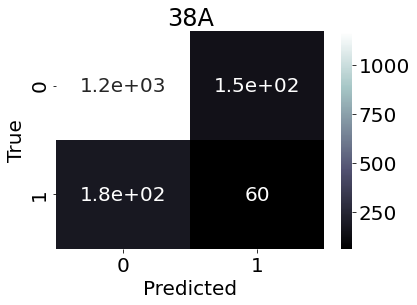

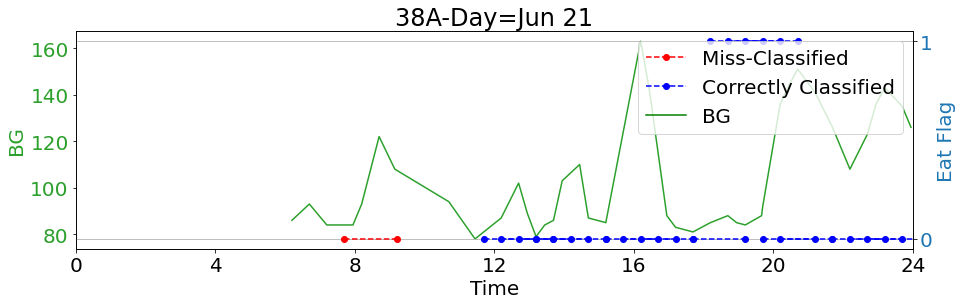

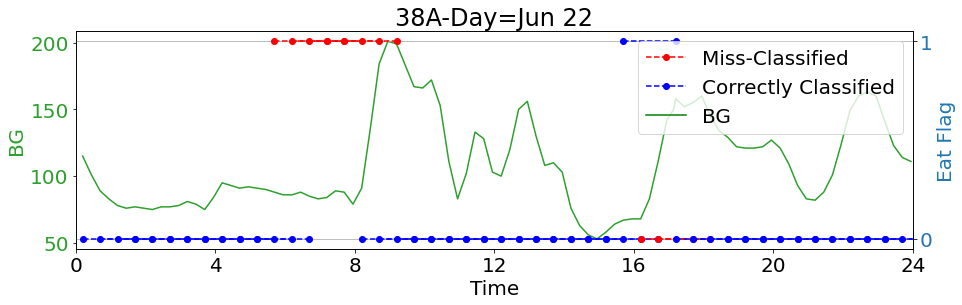

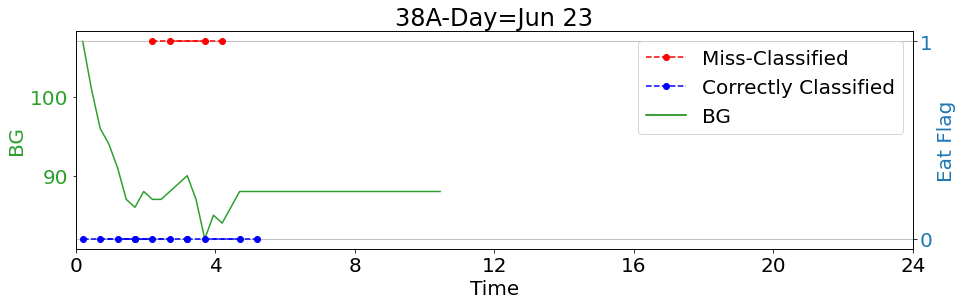

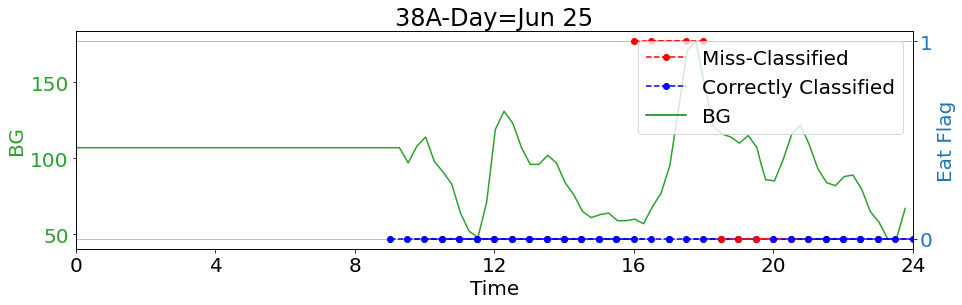

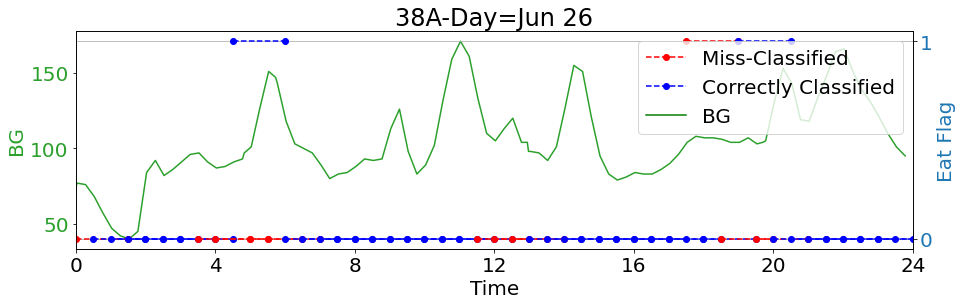

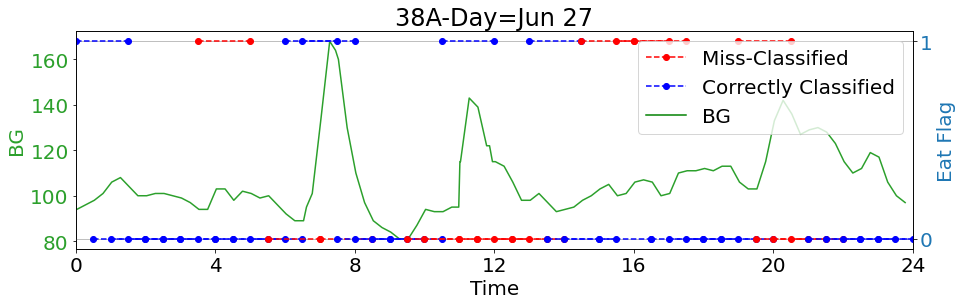

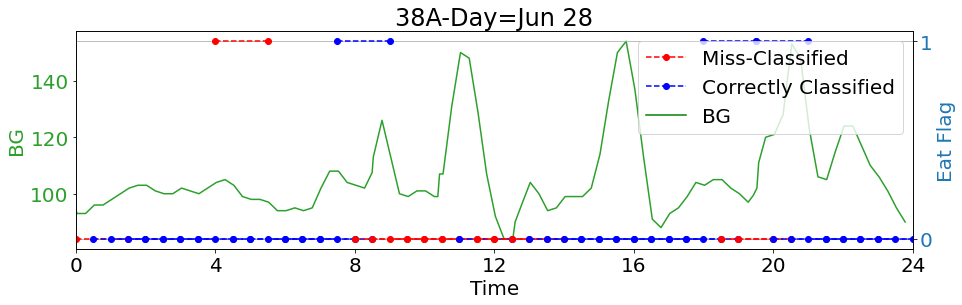

In [ ]:
#Chopping the data into daily values and forming the sliddingWindow
def sliddingWindowMakerTest(allDays,rawData):
    sliddingWindow=[]
    sliddingWindowLabel=[]
    for dayCounter in range(len(allDays)):
        currentDay=allDays[dayCounter]
        dayQuery=rawData[rawData['Day of Year']==currentDay]
        startTime=dayQuery.iloc[0,2]
        endTime=startTime+timeWindow
        fastingBG=fastingBGFinder(dayQuery,currentDay)

        windowQuery=dayQuery[dayQuery['Time']>=startTime]
        windowQuery=windowQuery[windowQuery['Time']<endTime]
        while startTime<24:
            if len(windowQuery)<4:
                startTime+=timeStep
                endTime+=timeStep
                windowQuery=dayQuery[dayQuery['Time']>=startTime]
                windowQuery=windowQuery[windowQuery['Time']<endTime]
                continue
            if windowQuery['Eat Flag'].sum()>=1:
                eatFlag=1
            else:
                eatFlag=0
            statInfo=statCalculator(windowQuery,fastingBG)
            statInfo=list(statInfo)
            statInfo.extend([startTime,endTime,currentDay])
            sliddingWindow.append(statInfo)
            sliddingWindowLabel.append(eatFlag)

            startTime+=timeStep
            endTime+=timeStep
            windowQuery=dayQuery[dayQuery['Time']>=startTime]
            windowQuery=windowQuery[windowQuery['Time']<endTime]

    sliddingWindow=np.array(sliddingWindow,dtype=float)
    sliddingWindowLabel=np.array(sliddingWindowLabel,dtype=int)
    return sliddingWindow,sliddingWindowLabel

def csvReaderTest(csvAddress):
    rawData=pd.read_csv(csvAddress)
    for myColumn in rawData.columns:
        if myColumn not in ['time','BG','Participant','Eat Flag','Test Day']:
            del rawData[myColumn]

    rawData['time']= pd.to_datetime(rawData['time'])
    rawData['BG']= pd.to_numeric(rawData['BG'])

    rawData=rawData.dropna()
    rawData=rawData.drop_duplicates(subset=['time'], keep='last')

    rawData.insert(2, "Day of Year",rawData['time'].dt.dayofyear)
    rawData.insert(3, "Time",rawData['time'].dt.hour+
                   rawData['time'].dt.minute/60+rawData['time'].dt.second/3600)
    rawData=rawData.drop(columns=['time'])
    rawData=rawData.sort_values(['Day of Year', 'Time'], ascending=[True, True])

    allDays=rawData['Day of Year'].tolist()
    allDays=set(allDays)
    allDays=list(allDays)

    return allDays,rawData

def windowVisualizerTest(rawData,bestModel,bestThreshold,patientName,sliddingWindow, sliddingWindowLabel, startTime,endTime,days):
    allDays=set(days)
    allDays=list(allDays)
    for dayCounter in range(len(allDays)):
        fig, ax1 = plt.subplots(figsize=(15,4))
        newQuery=rawData[rawData['Day of Year']==allDays[dayCounter]]

        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('BG', color=color)
        ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim([0,24])
        ax1.set_xticks(np.arange(0, 26, 4))

        tempData=[]
        tempLabel=[]
        tempStart=[]
        tempEnd=[]
        for counter in range(sliddingWindow.shape[0]):
            if days[counter]==allDays[dayCounter]:
                tempData.append(sliddingWindow[counter,:])
                tempLabel.append(sliddingWindowLabel[counter])
                tempStart.append(startTime[counter])
                tempEnd.append(endTime[counter])

        tempData=np.array(tempData,dtype=float)
        tempLabel=np.asarray(tempLabel,dtype=int)
        tempStart=np.asarray(tempStart,dtype=float)
        tempEnd=np.asarray(tempEnd,dtype=float)

        if len(tempData)==0:
            sys.exit(("--------Warning, the slidding window is empty for prediction on day:"+allDays[dayCounter]))

        tempPred=bestModel.predict_proba(tempData)
        tempPred=tempPred[:,1]
        tempPred[tempPred>=bestThreshold]=1
        tempPred[tempPred<bestThreshold]=0

        ax2 = ax1.twinx()
        for counter in range(len(tempPred)):
            if tempPred[counter]==tempLabel[counter]:
                ax2.plot([tempStart[counter],tempEnd[counter]],np.ones((2,1))*tempPred[counter],
                         linestyle='--', marker='o', color='b')
            else:
                ax2.plot([tempStart[counter],tempEnd[counter]],np.ones((2,1))*tempPred[counter],
                         linestyle='--', marker='o', color='r')
        ax2.plot([],[],linestyle='--', marker='o', color='r',label='Miss-Classified')
        ax2.plot([],[],linestyle='--', marker='o', color='b',label='Correctly Classified')
        ax2.plot([],[],linestyle='-', color='g',label='BG')
        ax2.legend()

        tempDate=datetime(2018, 1, 1) + timedelta(allDays[dayCounter] - 1)
        tempDate=tempDate.strftime("%b %d")
        plt.title(patientName+"-Day="+tempDate,color='black')

        color='tab:blue'
        ax2.set_ylabel('Eat Flag', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([0,1])
        ax2.set_xlim([0,24])
        ax2.set_xticks(np.arange(0, 26, 4))

        plt.grid()
        plt.show()

def predictorTest(patientName,modelingMethod,modelAddRoot,sliddingWindowTest,sliddingWindowLabelTest,threshBest):
    if modelingMethod=='RF':
        tempModelName=modelAddRoot+"RF"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))
    if modelingMethod=='XG':
        tempModelName=modelAddRoot+"XG"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))

    dataPred=modelBest.predict_proba(sliddingWindowTest[:,0:11])
    dataPred=dataPred[:,1]
    dataPred[dataPred>=threshBest]=1
    dataPred[dataPred<threshBest]=0

    confMatrix=sklearn.metrics.confusion_matrix(sliddingWindowLabelTest,dataPred)
    accuracy=sklearn.metrics.accuracy_score(sliddingWindowLabelTest,dataPred)
    recall=sklearn.metrics.recall_score(sliddingWindowLabelTest,dataPred)
    precision=sklearn.metrics.precision_score(sliddingWindowLabelTest,dataPred)

    print("The best model for participant:",patientName,"has accuracy=",round(accuracy*100,1)
          ,"recall=",round(recall*100,1),"precision=",round(precision*100,1))
    plt.figure()
    sns.heatmap(confMatrix, annot=True,cmap='bone')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(patientName)
    return modelBest

def participantReaderTest(plotFlag,modelingMethod):
    if not macFlag:
        csvFileAddRoot="C:\\GitHub\\STMI-CGM\\"
        modelAddRoot="C:\\GitHub\\STMI-CGM\\Sanitized38\\"
    else:
        #AMIN
        csvFileAddRoot=''
        modelAddRoot=''

    # patientNames=['38A','38B','38C','38D','38E','38F','38H']
    patientNames=['38A']
    for counter in range(len(patientNames)):
        threshBest=0.6#----------------------------------Change this line
        patientName=patientNames[counter]
        fileName=csvFileAddRoot+"all_record_SICONG_"+patientName+".csv"
        print('Reading.....',patientName)

        allDays,rawDataTest=csvReaderTest(fileName)
        sliddingWindowTest,sliddingWindowLabelTest=sliddingWindowMakerTest(allDays,rawDataTest)
        modelBest=predictorTest(patientName,modelingMethod,modelAddRoot,sliddingWindowTest,sliddingWindowLabelTest,threshBest)
        if plotFlag:
            windowVisualizerTest(rawDataTest,modelBest,threshBest,patientName,sliddingWindowTest[:,0:11],
                                 sliddingWindowLabelTest,sliddingWindowTest[:,11],sliddingWindowTest[:,12],
                                 sliddingWindowTest[:,13])

timeWindow=90/60
timeStep=30/60
breakfastTime=8
plotFlag=True
modelingMethod='RF'#XG,RF
participantReaderTest(plotFlag,modelingMethod)